## **Mapping Fire Impacts - LiDAR-based**

#### Reflection exercises for each group:

1. At the top of the Colab notebook that you share with everyone, please include your responses to the following questions:
  - Choose at least 1 dataset to explore in more detail.
  - What is the projection for this dataset?
  - Where can you find more information on how the data were collected and how to interpret the metadata?
  - Think about what data type each variable is.
  - Is it vector or raster data? What properties exist for each dataset?
  - What resolution are your data?

2. At the top of the Colab notebook, write a short summary detailing the processing steps in the notebook and your results.
  - Although these topics may be far removed from your own interests, how could these steps and analyses help in your own work?

3. OPTIONAL - Expand your script by adding additional processing, analysis, or other data.

As you're working through your exercise, **add code chunks to further document your scripts. Add additional comments to the code itself to clarify complicated processes.**




---



### Objectives
After completing this exercise, you will be able to:

* Use Python functions to programmatically download NEON AOP data from the API
* Download and plot shapefiles and kmls (included as lidar metadata) to visualize coverage for a given year
* Explore and plot the AOP discrete lidar point cloud contents in Python using the `laspy` package
* Read in and plot the AOP L3 raster data products (CHM, DTM, DSM) in Python using the `rasterio` package

Acknowledgement:
> The National Ecological Observatory Network is a program sponsored by the National Science Foundation and operated under cooperative agreement by Battelle. This material is based in part upon work supported by the National Science Foundation through the NEON Program."

This notebook was adapted from [Detecting changes in vegetation structure following fires using discrete-return LiDAR](https://github.com/NEONScience/NEON-Data-Skills/blob/main/tutorials/Python/AOP/Lidar/lidar-applications/lidar-wildfire/fire-effects-veg-structure-lidar.md), as well as the [Introduction to NEON Discrete Lidar Data in Python](https://github.com/NEONScience/NEON-Data-Skills/blob/main/tutorials/Python/AOP/Lidar/intro-lidar/intro_point_clouds_py/intro_discrete_point_clouds.md). The [NEON learning hub](https://www.neonscience.org/resources/learning-hub) is a great resource to learn more!

<div id="ds-objectives" markdown="1">

### Background

The **Creek Fire** was a large wildfire that started in September 2020 in the Sierra National Forest, California and became one of the largest fires of the [2020 California wildfire season](https://en.wikipedia.org/wiki/2020_California_wildfires). This fire had burned into NEON's [Soaproot Saddle (SOAP)](https://www.neonscience.org/field-sites/soap) site by mid-September, causing a [high intensity burn over much of the site](https://www.neonscience.org/impact/observatory-blog/domain-digest-no-4-fire-field-sites-and-recovery) - standing trees became charcoal spires, shrubs and their root systems burned completely, the thick litter layer was incinerated, and the soil severely burned.

The NEON Airborne Observation Platform (AOP) conducted aerial surveys over SOAP in 2019 and 2021, a year before and after the Creek Fire. This exercise aims to study the effects of fire on vegetation structure by comparing the lidar-derived relative height percentiles before and after the fire. In addition to the discrete return data, this tutorial uses a Digital Terrain Model (DTM) to determine the relative height of the discrete returns with respect to the ground.

This Python tutorial is broken down into three parts:
1. Read the NEON discrete-return lidar data ([DP1.30003.001](https://data.neonscience.org/data-products/DP1.30003.001)) and visualize the 3D lidar point cloud.
2. Read the lidar-derived Digital Terrain Model ([DP3.30024.001](https://data.neonscience.org/data-products/DP3.30024.001)) in Python. Visualize the spatial extent of the lidar data used in this tutorial with that of the Creek Fire perimeter and the SOAP flight boundary.
3. Calculate and compare the relative height percentiles of the discrete returns before and after the 2020 Creek Fire.

NEON provides both discrete return and full-waveform LiDAR data for its field sites across the US. The discrete return LiDAR point cloud differs from the full waveform data as it is considerably smaller in file size and condenses the information into a small number of points per laser shot rather than many data bins (roughly 100 bins per laser shot in the full waveform data).

#### Import Packages

In [ ]:
!pip install rasterio
!pip install rioxarray
!pip install laspy[lazrs,laszip]
!pip install pyproj
!pip install shapely
!pip install seaborn
!pip install geopandas
#an acronym of “pip Install Packages” is today the standard tool for installing Python packages

#import required packages
import requests
import geopandas as gpd
import pandas as pd
import numpy as np
import laspy, glob, os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d import axes3d
import pyproj
from pyproj import Proj
import shapely
from shapely import Polygon, MultiPolygon  ## Try this if this line throws an error: from shapely.geometry import Polygon, MultiPolygon
import seaborn as sns
import rasterio
import rioxarray
import geopandas as gpd
from rasterio.plot import show
import random
#import warnings
#warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 743.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.0/313.0 kB 29.0 MB/s eta 0:00:00


If you haven't saved the neon_aop_download_functions.py script locally, you can do that programmatically as follows:

In [ ]:
url = "https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/tutorials/Python/AOP/aop_python_modules/neon_aop_download_functions.py"
response = requests.get(url)
open("neon_aop_download_functions.py", "wb").write(response.content)

6722

Now we'll pull in all the functions in the module **neon_aop_download_functions.py**.

First make sure this script is saved in your working directory, which we can check by navigating into that directory, or by using `os.listdir`. If you haven't saved it in your working directory, you will need to provide the relative path to this script when importing.

```python
# check that script is saved in same folder:
os.listdir()
```

Once you've confirmed that the `neon_aop_download_functions script` is in your working directory, you can import the contents of this file as follows:

In [ ]:
from neon_aop_download_functions import *

Alternatively, if you'd like to see the contents of that file in your notebook, you can use the "magic" command `%load` as follows:

```python
%load neon_aop_download_functions.py
```

If you go this route, you will need to run the cell twice for the functions to be read into the notebook. The first run will load the functions into the cell, and the second run will load the functions into the working environment. This option of loading in the functions may be useful if you wish to modify the functions locally, eg. according to your specific workflow.

Now that we've imported in all the required packages and functions, we can get started! First let's take a look at what exactly we've imported by using the magic command `%whos`. Since there is no variable explorer in Jupyter Notebooks, this is a quick way to see the contents (variables, functions, modules, etc.) that have been loaded in our current environment.

In [ ]:
%whos

Variable                      Type        Data/Info
---------------------------------------------------
Line2D                        type        <class 'matplotlib.lines.Line2D'>
MultiPolygon                  type        <class 'shapely.geometry.<...>ltipolygon.MultiPolygon'>
Patch                         type        <class 'matplotlib.patches.Patch'>
Polygon                       type        <class 'shapely.geometry.polygon.Polygon'>
Proj                          type        <class 'pyproj.proj.Proj'>
axes3d                        module      <module 'mpl_toolkits.mpl<...>lkits/mplot3d/axes3d.py'>
download_aop_files            function    <function download_aop_files at 0x7bf50074b250>
download_file                 function    <function download_file at 0x7bf50074b130>
download_urls                 function    <function download_urls at 0x7bf50074b0a0>
get_file_size                 function    <function get_file_size at 0x7bf50074b1c0>
glob                          module      <modul

#### Data Tip
If you are unsure what a function or module does, you can find more information about the function in two ways:
1. type `help(function_name)`, which will print out documentation below the cell, or
2. type the function name followed by `?`, which will pop up the documentation at the bottom of your Jupyter Notebook window, and you can then exit out of it at your convenience

```python
help(requests)
requests?
```

The functions loaded from the `neon_aop_download_functions.py` file also include similar documentation, so you can also use the help function with for user-defined functions, as long as the appropriate `docstrings` (comments) have been added.

```python
help(list_available_urls)
list_available_urls?
```

Now that we've pulled in the packages needed for the first part of the tutorial, we can download a dataset from the NEON API.

First we'll start by defining variables that specify the NEON data product ID (`dpID`), site, and year. You can change the site code to look at a different site of your interest (for more detailed information about the NEON sites, please check out the <a href="https://www.neonscience.org/field-sites/explore-field-sites" target="_blank">Explore Field Sites</a> webpage.

In [ ]:
dpID='DP1.30003.001'
site = 'SOAP'

We can use the function `list_available_urls` to see what data is available for this data product and site. This function requires two inputs: the data product ID `dpID` and the site ID, `site`.

In [ ]:
help(list_available_urls)

Help on function list_available_urls in module neon_aop_download_functions:

list_available_urls(product, site)
    list_available urls lists the api url for a given product and site
    --------
     Inputs:
         product: the data product code (eg. 'DP3.30015.001' - CHM)
         site: the 4-digit NEON site code (eg. 'SRER', 'JORN')
    --------
    Usage:
    --------
    jorn_chm_urls = list_available_urls('DP3.30015.001','JORN')



In [ ]:
list_available_urls(dpID,site)

['https://data.neonscience.org/api/v0/data/DP1.30003.001/SOAP/2013-06',
 'https://data.neonscience.org/api/v0/data/DP1.30003.001/SOAP/2017-07',
 'https://data.neonscience.org/api/v0/data/DP1.30003.001/SOAP/2018-06',
 'https://data.neonscience.org/api/v0/data/DP1.30003.001/SOAP/2019-06',
 'https://data.neonscience.org/api/v0/data/DP1.30003.001/SOAP/2021-07',
 'https://data.neonscience.org/api/v0/data/DP1.30003.001/SOAP/2023-06',
 'https://data.neonscience.org/api/v0/data/DP1.30003.001/SOAP/2023-07']

The AOP has only flown Puerto Rico (D04) once so far, in 2018. D04 is only on the AOP schedule every 4 years; the next campaign is scheduled for the fall of 2022, so new data is expected relatively soon!

Next let's set up some paths where we can save our downloaded data. We'll start with downloading geospatial metadata in order to get a sense of the coverage (geographic extents) of the flight area. We'll make a folder for the shapefiles (shp), kml files (which may be useful for interactively looking at the site boundaries in Google Earth), and a folder for the actual lidar (laz) data.

In [ ]:
year='2021'
year2='2019'
data_root_path = './data/'+site+'/'+year+'/'
data_root_path2 = './data/'+site+'/'+year2+'/'
shp_path = data_root_path+'shp/'
shp_path2 = data_root_path2+'shp/'
kml_path = data_root_path+'kml/'
kml_path2 = data_root_path2+'kml/'
laz_path = data_root_path+'laz/'
laz_path2 = data_root_path2+'laz/'
print(data_root_path)
print(data_root_path2)

./data/SOAP/2021/
./data/SOAP/2019/


Next, let's take a look at the `download_aop_files` function, which we'll use to download the metadata and data that we want to explore.

In [ ]:
help(download_aop_files)

Help on function download_aop_files in module neon_aop_download_functions:

download_aop_files(product, site, year=None, download_folder='./data', match_string=None, check_size=True)
    download_aop_files downloads NEON AOP files from the AOP for a given data product, site, and 
    optional year, download folder, and 
    --------
     Inputs:
         required:
             product: the data product code (eg. 'DP3.30015.001' - CHM)
             site: the 4-digit NEON site code (eg. 'SRER', 'JORN')
         
         optional:
             year: year (eg. '2020'); default (None) is all years
             download_folder: folder to store downloaded files; default (./data) in current directory
             match_string: subset of data to match, need to use exact pattern for file name
             check_size: prompt to continue download (y/n) after displaying size; default = True
    --------
    Usage:
    --------
    download_aop_files('DP3.30015.001','JORN','2019','./data/JORN_2019/

The only required inputs for this function are the `product` and the `site`; optionally we can specify the `year`, the `download_folder` to save the files, and a `match_string` to download a subset of the data by a string. By default, the function will display the size of the files, and prompt the user to continue the download (by typing `y`); any other response will halt the download. This is to prevent an accidental download of a large volume of data.

### Lidar Metadata

We'll start by downloading the some of the metadata, including the pdf documentation, and shape files that provide geographic information corresponding to the data. Because AOP data can be pretty large for an entire site, and you may only need to work with a subset of the data for a given site, we recommend starting with downloading only the metadata.

#### Lidar Documentation - QA pdfs

AOP data provides summary pdf documents, which include important information about the sensors used to collect the lidar data, acquisition parameters, processing parameters, and QA information. When working with any AOP data, we recommend reviewing this documentation, as well as referencing the relevant ATBDs.

In [ ]:
#download the QA reports to the default download directory (./data)
download_aop_files(dpID,site,year,match_string='.pdf',check_size=False)
download_aop_files(dpID,site,year2,match_string='.pdf',check_size=False)

Download size: 26.97 MB
downloading 2021071215_P1C2_SBET_QAQC.pdf to ./data
downloading 2021_SOAP_5_L3_discrete_lidar_processing.pdf to ./data
downloading 2021_SOAP_5_L1_discrete_lidar_processing.pdf to ./data
downloading 2021071315_P1C2_SBET_QAQC.pdf to ./data
Download size: 27.53 MB
downloading 2019061115_P2C1_SBET_QAQC.pdf to ./data
downloading 2019061515_P2C1_SBET_QAQC.pdf to ./data
downloading 2019_SOAP_4_L1_discrete_lidar_processing.pdf to ./data
downloading 2019061315_P2C1_SBET_QAQC.pdf to ./data
downloading 2019_SOAP_4_L3_discrete_lidar_processing.pdf to ./data
downloading 2019061615_P2C1_SBET_QAQC.pdf to ./data
downloading 2019061415_P2C1_SBET_QAQC.pdf to ./data


Please take a look at these pdfs on your own time!

#### Download and Plot Shapefile Boundaries

There are summary shape files provided along with the lidar data for each site. These summary files end with `merged_tiles.shp/.shx`, so we can key off that string to download only the full boundary shape file. You could also download all of the individual `.shp` files for each data tile (L3 data is provided in 1km x 1km tiles), by using the match string `.shp`, or similarly all the `.kml` files, if you wanted to pull the data boundaries into Google Earth and explore more interactively.

We'll download the merged_tiles shapefiles (you need to download both extensions .shp and .shx):

In [ ]:
#download the full-boundary shape files
download_aop_files(dpID,site,year,shp_path,'merged_tiles.shp',check_size=False)
download_aop_files(dpID,site,year,shp_path,'merged_tiles.shx',check_size=False)

download_aop_files(dpID,site,year2,shp_path2,'merged_tiles.shp',check_size=False)
download_aop_files(dpID,site,year2,shp_path2,'merged_tiles.shx',check_size=False)

Download size: 1.53 MB
downloading NEON_D17_SOAP_DPQA_2021_merged_tiles.shp to ./data/SOAP/2021/shp/
Download size: 0.0 kB
downloading NEON_D17_SOAP_DPQA_2021_merged_tiles.shx to ./data/SOAP/2021/shp/
Download size: 0.89 kB
downloading 2019_SOAP_4_merged_tiles.shp to ./data/SOAP/2019/shp/
Download size: 0.0 kB
downloading 2019_SOAP_4_merged_tiles.shx to ./data/SOAP/2019/shp/


We can see that these files have downloaded to the expected location by listing the contents of the `shp_path` directory that we've made:

In [ ]:
os.listdir(shp_path)

['NEON_D17_SOAP_DPQA_2021_merged_tiles.shp',
 'NEON_D17_SOAP_DPQA_2021_merged_tiles.shx']

In [ ]:
os.listdir(shp_path2)

['2019_SOAP_4_merged_tiles.shp', '2019_SOAP_4_merged_tiles.shx']

We can see these files in the `shp` directory we created. Next, let's plot the boundary shapefile data using `geopandas` (imported as `gpd`) as follows:

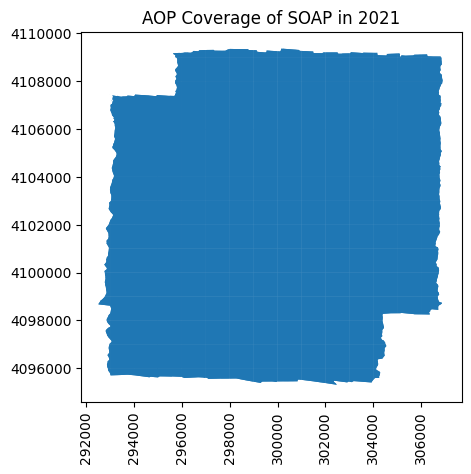

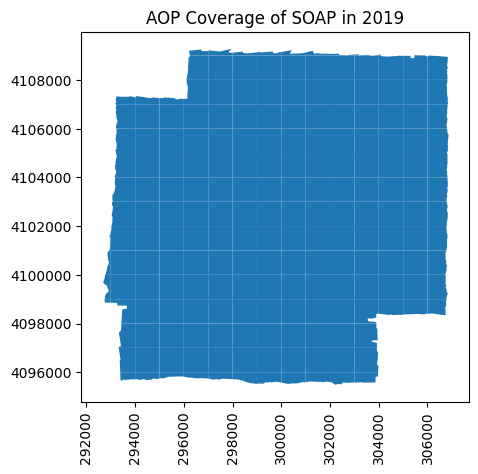

In [ ]:
gdf = gpd.read_file(os.path.join(shp_path,'NEON_D17_SOAP_DPQA_2021_merged_tiles.shp'))
gdf.plot();
ax = plt.gca(); ax.ticklabel_format(style='plain')
ax.set_title('AOP Coverage of ' + site + ' in ' + year);
plt.xticks(rotation=90); #optionally rotate the xtick labels

gdf = gpd.read_file(os.path.join(shp_path2,'2019_SOAP_4_merged_tiles.shp'))
gdf.plot();
ax = plt.gca(); ax.ticklabel_format(style='plain')
ax.set_title('AOP Coverage of ' + site + ' in ' + year2);
plt.xticks(rotation=90); #optionally rotate the xtick labels

In [ ]:
download_aop_files(dpID,site,year,kml_path,'full_boundary.kml',check_size=False)
download_aop_files(dpID,site,year2,kml_path2,'full_boundary.kml',check_size=False)

Download size: 0.14 kB
downloading NEON_D17_SOAP_DPQA_2021_full_boundary.kml to ./data/SOAP/2021/kml/
Download size: 0.15 kB
downloading NEON_D17_SOAP_DP1_2019_full_boundary.kml to ./data/SOAP/2019/kml/


In [ ]:
download_aop_files('DP1.30003.001',site,year,laz_path,match_string='293000_4100000_classified_point_cloud_colorized.laz')
download_aop_files('DP1.30003.001',site,year2,laz_path2,match_string='293000_4100000_classified_point_cloud_colorized.laz')

Download size: 119.25 MB
Do you want to continue with the download? (y/n) y
downloading NEON_D17_SOAP_DP1_293000_4100000_classified_point_cloud_colorized.laz to ./data/SOAP/2021/laz/
Download size: 21.4 MB
Do you want to continue with the download? (y/n) y
downloading NEON_D17_SOAP_DP1_293000_4100000_classified_point_cloud_colorized.laz to ./data/SOAP/2019/laz/


We can use `os.listdir` again to check that this file successfully downloaded to the expected location. Alternatively you could go into your file explorer.

In [ ]:
os.listdir(laz_path)

['NEON_D17_SOAP_DP1_293000_4100000_classified_point_cloud_colorized.laz']

In [ ]:
os.listdir(laz_path2)

['NEON_D17_SOAP_DP1_293000_4100000_classified_point_cloud_colorized.laz']

### Exploring point cloud data with `laspy`

Now that we've successfully downloaded a laz (or zipped las) file, we can use the `laspy` package to read it in! We'll do that in the next line, reading the lidar file into the variable name `point_cloud`:

In [ ]:
# use os.path.join to get the full path of the laz file
point_cloud_2021=os.path.join(laz_path,'NEON_D17_SOAP_DP1_293000_4100000_classified_point_cloud_colorized.laz')
# read the laz file into a LasData object using laspy.read()
las_2021=laspy.read(point_cloud_2021)

In [ ]:
# use os.path.join to get the full path of the laz file
point_cloud_2019=os.path.join(laz_path2,'NEON_D17_SOAP_DP1_293000_4100000_classified_point_cloud_colorized.laz')
# read the laz file into a LasData object using laspy.read()
las_2019=laspy.read(point_cloud_2019)

Reading in the file with with laspy.read() reads in both the metadata and the raw point cloud data. We can print out the `point_cloud` variable to show some basic information about what we've read in:

In [ ]:
las_2021

<LasData(1.4, point fmt: <PointFormat(7, 0 bytes of extra dims)>, 15278262 points, 4 vlrs)>

In [ ]:
las_2019

<LasData(1.3, point fmt: <PointFormat(3, 0 bytes of extra dims)>, 3015329 points, 2 vlrs)>

`point_format.dimension_names` show us the available information stored in this LasData object format:

In [ ]:
list(las_2021.point_format.dimension_names)

['X',
 'Y',
 'Z',
 'intensity',
 'return_number',
 'number_of_returns',
 'synthetic',
 'key_point',
 'withheld',
 'overlap',
 'scanner_channel',
 'scan_direction_flag',
 'edge_of_flight_line',
 'classification',
 'user_data',
 'scan_angle',
 'point_source_id',
 'gps_time',
 'red',
 'green',
 'blue']

In the next few cells, we can explore some of these variables:

In [ ]:
las_2021.classification

array([2, 2, 2, ..., 7, 7, 7], dtype=uint8)

Let's get the `set` of this `list` to see all the unique classification values in this file. This may take a little time to run.

In [ ]:
set(list(las_2021.classification))

{1, 2, 5, 6, 7}

We can see that there are a several unique classification values for this site.
Las files have "predefined classification schemes defined by the American Society for Photogrammetry and Remote Sensing (ASPRS)". You can refer to the <a href="https://desktop.arcgis.com/en/arcmap/10.3/manage-data/las-dataset/lidar-point-classification.htm" target="_blank">ArcGIS documentation</a> for more details.

The following table lists the LAS classification codes defined by ASPRS for these LAS versions:

| Classification value | Meaning           |
|---------------------|-------------------|
| 0                   | Never classified  |
| 1                   | Unassigned        |
| 2                   | Ground            |
| 3                   | Low Vegetation    |
| 4                   | Medium Vegetation |
| 5                   | High Vegetation   |
| 6                   | Building          |
| 7                   | Low Point         |

Next let's take a look at what we can consider to be the main data - the geographic loation of each point in the point cloud. This can be accessed either by `point_cloud.xyz`. Let's take a look:

In [ ]:
## Function to import las file as a dataframe in python
def las_to_df(las):
  x = pd.DataFrame(np.array(las.x))
  y = pd.DataFrame(np.array(las.y))
  z = pd.DataFrame(np.array(las.z))
  intensity = pd.DataFrame(np.array(las.intensity))
  return_num = pd.DataFrame(np.array(las.return_number))
  number_of_returns = pd.DataFrame(np.array(las.number_of_returns))
  classification = pd.DataFrame(np.array(las.classification)) ## 0 - 31 as per ASPRS classification scheme

  df = pd.concat([x, y, z, intensity, return_num, number_of_returns, classification], axis=1)
  df.columns=["x", "y", "z", "intensity", "return_num", "number_of_returns", "classification"]
  return(df)

In [ ]:
## Call the las_to_df function to extract the 2019 and 2021 data as separate dataframes
point_cloud_df_2019 = las_to_df(las_2019)
point_cloud_df_2021 = las_to_df(las_2021)
point_cloud_df_2021.head()

,x,y,z,intensity,return_num,number_of_returns,classification
0,293396.362,4100000.012,907.778,25,3,3,2
1,293396.347,4100000.014,907.762,27,3,3,2
2,293396.324,4100000.019,907.710,32,3,3,2
3,293396.336,4100000.016,907.754,36,3,3,2
4,293396.323,4100000.019,907.714,36,3,3,2


In [ ]:
## Use np.stack to combine the X, Y and Z into one array
## Convert (3 x n) array to (n x 3) using transpose
point_data_2021 = np.stack([las_2021.X, las_2021.Y, las_2021.Z]).transpose()
point_data_2019 = np.stack([las_2019.X, las_2019.Y, las_2019.Z]).transpose()
print("Number of discrete returns in the 2021 point cloud file = %s" %"{:,}".format(point_data_2021.shape[0]))
print("Number of discrete returns in the 2019 point cloud file = %s" %"{:,}".format(point_data_2019.shape[0]))

Number of discrete returns in the 2021 point cloud file = 15,278,262
Number of discrete returns in the 2019 point cloud file = 3,015,329


There are > 2 million lidar points in this single 1km x 1km tile. For the rest of this exercise, we'll look at a random subset of these points, taking every100th point (you can change this subset factor, but when we visualize the data in a few steps, subsetting by a larger factor will speed up the time it takes to make the plot).

In [ ]:
factor=100
point_data_2021_sub = point_data_2021[::factor]
point_data_2019_sub = point_data_2019[::factor]
print("Number of discrete returns in the 2021 point cloud subsample = %s" %"{:,}".format(point_data_2021_sub.shape[0]))
print("Number of discrete returns in the 2019 point cloud subsample = %s" %"{:,}".format(point_data_2019_sub.shape[0]))

Number of discrete returns in the 2021 point cloud subsample = 152,783
Number of discrete returns in the 2019 point cloud subsample = 30,154


These point clouds have been "colorized" by the camera RGB imagery. If you refer back to the dimension names, you can see there are a `red`, `green`, and `blue` attributes. We can pull these into a single array by using `np.vstack`:

In [ ]:
colors_2021 = np.stack([las_2021.red, las_2021.green, las_2021.blue]).transpose()
colors_2019 = np.stack([las_2019.red, las_2019.green, las_2019.blue]).transpose()

These colors have been scaled to store the color at a higher resolution, accomodated by the camera, so we'll need to re-scale the values between 0-1 in order to use them in our plot. The code below does this re-scaling, and then subsets the color data to by same factor we used to subset the `xyz` data.

In [ ]:
colors_2021_normalized = (colors_2021 - np.min(colors_2021))/np.ptp(colors_2021)
colors_2021_normalized_sub = colors_2021_normalized[::factor]
## We are going to zip the R,G,B values together for plotting using the matplotlib package
colors_2021_normalized_sub = list(zip(colors_2021_normalized_sub[:,0], colors_2021_normalized_sub[:,1], colors_2021_normalized_sub[:,2]))

colors_2019_normalized = (colors_2019 - np.min(colors_2019))/np.ptp(colors_2019)
colors_2019_normalized_sub = colors_2019_normalized[::factor]
colors_2019_normalized_sub = list(zip(colors_2019_normalized_sub[:,0], colors_2019_normalized_sub[:,1], colors_2019_normalized_sub[:,2]))

### 3D Point Cloud Visualization
Lastly, we can visualize this 3D data using matplotlib to see what the point cloud looks like.

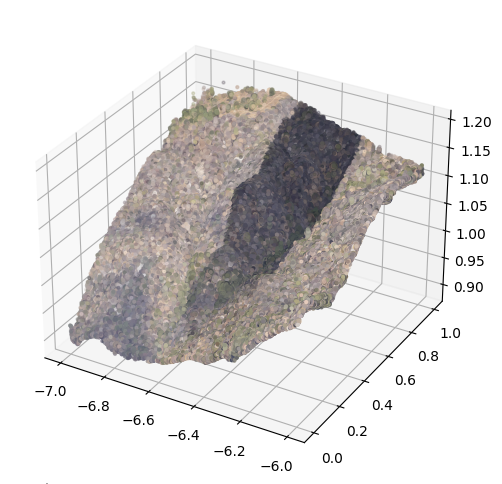

In [ ]:
# Plot the las data in 3D
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

## Plot the 2021 data
ax.scatter(point_data_2021_sub[:,0], point_data_2021_sub[:,1], point_data_2021_sub[:,2], color=colors_2021_normalized_sub, s=4)
plt.show()

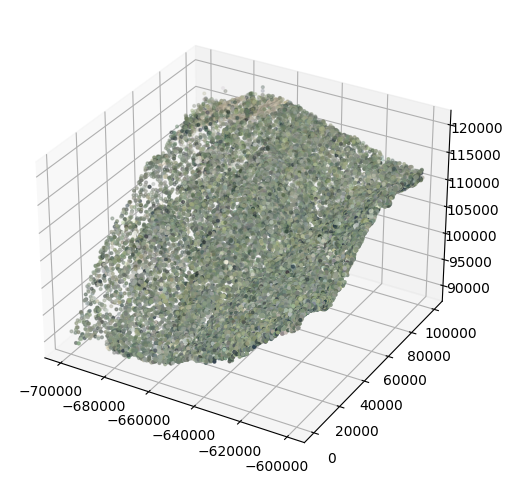

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(point_data_2019_sub[:,0], point_data_2019_sub[:,1], point_data_2019_sub[:,2], color=colors_2019_normalized_sub, s=4)
plt.show()

### Lidar Raster Data - DTM, DSM, and CHM

Lastly, we'll take a look at some of the derived (Level-3, or L3) data products generated from this point cloud data. NEON generates 5 different derived L3 products from the discrete data, summarized below.

In the last part of this lesson, we'll show how to read in and visualize the CHM, DTM, and DSM data using the Python package `rasterio`. First we'll import the package and sub-package that's used to display the data

In [ ]:
import rasterio
from rasterio.plot import show

In the next couple cells, we'll create a path to save the raster data, and then download the L3 CHM, DTM, and DSM geotiffs of the same tile as the point cloud file we downloaded earlier. You'll see the syntax here is the same, we are just using different data product IDs and match_strings with the appropriate extensions.

In [ ]:
l3_path = data_root_path+'L3/'
l3_path2 = data_root_path2+'L3/'

In [ ]:
download_aop_files('DP3.30015.001',site,year,l3_path,match_string='293000_4100000_CHM.tif',check_size=False)
download_aop_files('DP3.30024.001',site,year,l3_path,match_string='293000_4100000_DTM.tif',check_size=False)
download_aop_files('DP3.30024.001',site,year,l3_path,match_string='293000_4100000_DSM.tif',check_size=False)

Download size: 4.02 MB
downloading NEON_D17_SOAP_DP3_293000_4100000_CHM.tif to ./data/SOAP/2021/L3/
Download size: 4.01 MB
downloading NEON_D17_SOAP_DP3_293000_4100000_DTM.tif to ./data/SOAP/2021/L3/
Download size: 4.01 MB
downloading NEON_D17_SOAP_DP3_293000_4100000_DSM.tif to ./data/SOAP/2021/L3/


In [ ]:
download_aop_files('DP3.30015.001',site,year2,l3_path2,match_string='293000_4100000_CHM.tif',check_size=False)
download_aop_files('DP3.30024.001',site,year2,l3_path2,match_string='293000_4100000_DTM.tif',check_size=False)
download_aop_files('DP3.30024.001',site,year2,l3_path2,match_string='293000_4100000_DSM.tif',check_size=False)

Download size: 4.02 MB
downloading NEON_D17_SOAP_DP3_293000_4100000_CHM.tif to ./data/SOAP/2019/L3/
Download size: 4.01 MB
downloading NEON_D17_SOAP_DP3_293000_4100000_DTM.tif to ./data/SOAP/2019/L3/
Download size: 4.01 MB
downloading NEON_D17_SOAP_DP3_293000_4100000_DSM.tif to ./data/SOAP/2019/L3/


Next we'll read these in, using `rasterio`, as follows:

In [ ]:
chm = rasterio.open(os.path.join(l3_path,'NEON_D17_SOAP_DP3_293000_4100000_CHM.tif'))
dtm = rasterio.open(os.path.join(l3_path,'NEON_D17_SOAP_DP3_293000_4100000_DTM.tif'))
dsm = rasterio.open(os.path.join(l3_path,'NEON_D17_SOAP_DP3_293000_4100000_DSM.tif'))

In [ ]:
chm2019 = rasterio.open(os.path.join(l3_path2,'NEON_D17_SOAP_DP3_293000_4100000_CHM.tif'))
dtm2019 = rasterio.open(os.path.join(l3_path2,'NEON_D17_SOAP_DP3_293000_4100000_DTM.tif'))
dsm2019 = rasterio.open(os.path.join(l3_path2,'NEON_D17_SOAP_DP3_293000_4100000_DSM.tif'))

And finally, we can plot the data using the rasterio `show` function that we imported earlier.

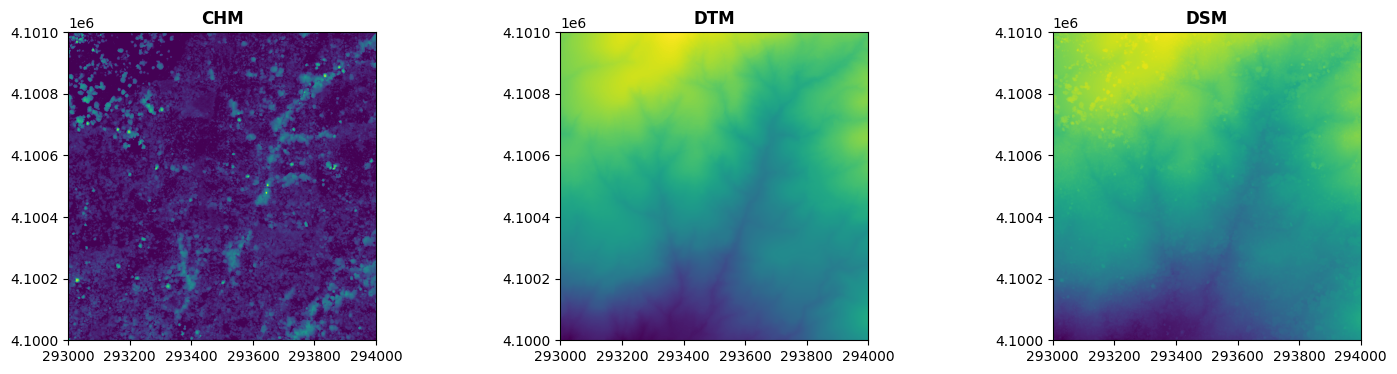

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))
show((chm), ax=ax1, title='CHM');
show((dtm), ax=ax2, title='DTM');
show((dsm), ax=ax3, title='DSM');
plt.show;

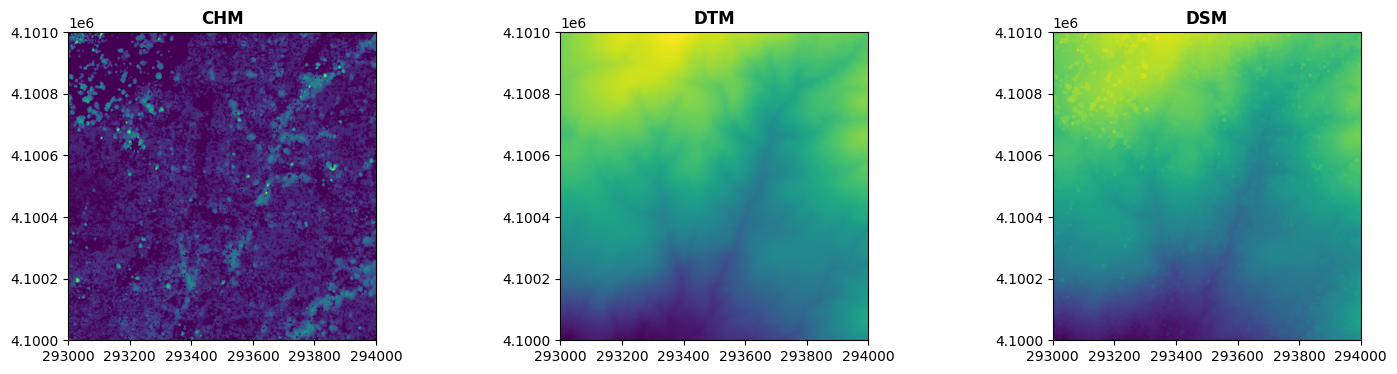

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))
show((chm2019), ax=ax1, title='CHM');
show((dtm2019), ax=ax2, title='DTM');
show((dsm2019), ax=ax3, title='DSM');
plt.show;

# Lidar Raster Data (notes)
* DSM, DTM and CHM are derived (Level-3, or L3) data products generated from this point cloud data
* Package - rasterio

<img src='https://drive.google.com/uc?export=view&id=10xcPfqTQVfzfNlaC6M72KoyVldwLzanu' width=800> Image credit: [OpenTopography](https://opentopography.org/lidar_basics)

DSM
* digital surface model
* a three-dimensional representation of the upper elevations of a landscape
* includes the bare surface and above-ground features like vegetation, buildings, and other structures.

DTM
* digital terrain model
* a three-dimensional representation of the bare ground surface
* natural and built features (i.e., vegetation and buildings) are removed from the landscape to show just the topography

CHM
* Canopy height models
* measurement of trees, vegetation, buildings, and other structures above the bare ground surface.
* CHM = DSM-DTM

2019 vs 2021

<img src='https://drive.google.com/uc?export=view&id=10xcov5Hk4sPvnDu2RwVTrQjm1ICZ3VlS' width=800> Image credit: [2019 vs 2021; note the darker areas in the 2021 plot]

### Calculate and compare the relative height percentiles of the discrete returns before (2019) and after (2021) the 2020 Creek fire.

We will now be calculating pixel-wise height percentiles ($20^{th}$, $30^{th}$, $50^{th}$, $75^{th}$, and $90^{th}$ percentile heights) of the discrete returns relative to the ground (DTM) for the years 2019 and 2021. To ensure that we have sufficient number of lidar returns per pixel for calculating percentiles, we will be calculating these metrics for every 10m pixel on the ground. So, our tasks here would be to:

1) Calculate heights of discrete returns with repect to the 1m DTM. Since the ground heights do not change from year to year, we will be using the 2021 DTM to calculate heights of the discrete returns with respect to ground for both the years 2019 and 2021. The 2020 fire event would have likely cleared up some of the low vegetation and ground litter, thereby improving ground detection post-fire in 2021. Therefore, the 2021 DTM may be a more accurate representation of the true ground compared to the 2019 DTM.
2) Create a 10m spatial resolution raster grid and assign a unique id to each 10m pixel.
3) Group all discrete returns based on the 10m pixel they fall into.
4) Calculate height percentiles ($20^{th}$, $30^{th}$, $50^{th}$, $75^{th}$, and $90^{th}$ percentile heights) relative to the ground for each 10m pixel.
5) Compare the distribution of heights for each height percentile before and after the fire.

### 1. Discrete-return heights relative to 2021 DTM

To extract the ground elevation associated with each discrete return, we will be sampling values from the 2021 DTM raster at the x,y locations of each discrete return. We can then subtract the ground elevation from the height of the discrete return (z) to get the height of the return above ground.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
## zip all x and y coordinates together for sampling rasters in the next cell
coords_2019 = [(x,y) for x, y in zip(point_cloud_df_2019["x"], point_cloud_df_2019["y"])]
coords_2021 = [(x,y) for x, y in zip(point_cloud_df_2021["x"], point_cloud_df_2021["y"])]

print("Number of discrete returns in 2021 data = %d" %len(coords_2021))
print("Number of discrete returns in 2019 data = %d" %len(coords_2019))

Number of discrete returns in 2021 data = 15278262
Number of discrete returns in 2019 data = 3015329


In [ ]:
## Set a seed value to make the code output reproducible
seed_val = 0
random.seed(seed_val)

## Randomly sample 1 million rows from the 2019 and 2021 point cloud dataframes
point_cloud_df_2019_sub = point_cloud_df_2019.sample(n=1000000).reset_index(drop=True)
point_cloud_df_2021_sub = point_cloud_df_2021.sample(n=1000000).reset_index(drop=True)

## zip all x and y coordinates together for sampling rasters in the next step
coords_2019_sub = [(x,y) for x, y in zip(point_cloud_df_2019_sub["x"], point_cloud_df_2019_sub["y"])]
coords_2021_sub = [(x,y) for x, y in zip(point_cloud_df_2021_sub["x"], point_cloud_df_2021_sub["y"])]

## Sample the raster using "rasterio.sample.sample_gen()"

## Sample the 2021 DTM raster for ground elevation at each (x,y) location of the 2021 discrete returns
dtm_vals_2021 = pd.DataFrame(list(rasterio.sample.sample_gen(dtm, coords_2021_sub)))

## Sample the 2021 DTM raster for ground elevation at each (x,y) location of the 2019 discrete returns
## The ground elevations shouldn't change from year to year, so it is OK to use the 2021 DTM for both years.
## Moreover, the fire event in 2020 likely cleared the understory vegetation, and therefore, the ground elevations might be more accurate in 2021
dtm_vals_2019 = pd.DataFrame(list(rasterio.sample.sample_gen(dtm2019, coords_2019_sub)))

In [ ]:
## Merge the point cloud dataframe (point_cloud_df_20xx_sub) with the DTM ground elevations extracted (dtm_vals_20xx)
## Calculate the relative height of each return with respect to ground ("discrete_ret_ht_above_ground")

## 2019
df_2019 = pd.concat([point_cloud_df_2019_sub, dtm_vals_2019], axis=1)
df_2019.columns = ["x", "y", "z", "intensity", "return_num", "number_of_returns", "classification", "ground_elevation"]
df_2019["discrete_ret_ht_above_ground"] = df_2019["z"] - df_2019["ground_elevation"]

## Do the same for 2021 data as well
df_2021 = pd.concat([point_cloud_df_2021_sub, dtm_vals_2021], axis=1)
df_2021.columns = ["x", "y", "z", "intensity", "return_num", "number_of_returns", "classification", "ground_elevation"]
df_2021["discrete_ret_ht_above_ground"] = df_2021["z"] - df_2021["ground_elevation"]
df_2021.head()

,x,y,z,intensity,return_num,number_of_returns,classification,ground_elevation,discrete_ret_ht_above_ground
0,293616.685,4100388.626,999.769,38,2,2,2,999.586975,0.182025
1,293426.300,4100424.802,1048.635,78,2,2,2,1048.508057,0.126943
2,293215.553,4100703.878,1126.263,164,1,1,2,1126.192017,0.070983
3,293613.111,4100187.647,990.544,169,1,1,2,990.478027,0.065973
4,293791.809,4100790.095,1083.880,187,1,1,2,1083.766968,0.113032


### 2. Create a 10m spatial resolution raster grid and assign a unique id to each 10m pixel


In [ ]:
## Create a (100 x 100) dataframe with each cell having a unique value between 0 and 10,000
ids = pd.DataFrame(data=np.arange(0, 100*100).reshape(100,100), index=np.arange(0,100), columns=np.arange(0,100))

## Create a scaled transform
scaled_transform = dtm.transform * dtm.transform.scale((10),(10))

## Using rasterio, save the dataframe as a 10m raster in the tif format
with rasterio.open(
    data_root_path + '/DTM_10m_unique_id.tif',
    'w',
    driver='GTiff',
    height=ids.shape[0],
    width=ids.shape[1],
    count=1,
    dtype=np.dtype(np.int32),
    crs=dtm.crs,
    transform=scaled_transform,
) as dst:
    dst.write(ids, 1)

<xarray.DataArray (band: 1, y: 100, x: 100)>
[10000 values with dtype=int32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 2.93e+05 2.93e+05 2.93e+05 ... 2.94e+05 2.94e+05
  * y            (y) float64 4.101e+06 4.101e+06 4.101e+06 ... 4.1e+06 4.1e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0


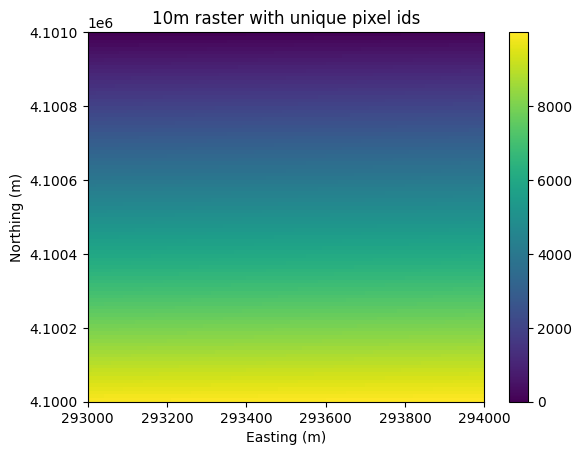

In [ ]:
## Use rioxarray again to plot the newly created 10m raster
raster_10m = rioxarray.open_rasterio(data_root_path + "DTM_10m_unique_id.tif")
print(raster_10m)
raster_10m.plot()
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.title("10m raster with unique pixel ids")
plt.show()

### 3. Group all discrete returns based on the 10m pixel they fall into.


In [ ]:
## Here, we assign unique ids created in the previous cell to each discrete return
## Sample the unique ids from the 10m raster for each discrete return for the years 2019 and 2021
## This sampling step might again take a few minutes

raster_10m = rasterio.open(data_root_path + "DTM_10m_unique_id.tif")
## For the year 2021
dtm_id_vals_2021 = pd.DataFrame(list(rasterio.sample.sample_gen(raster_10m, coords_2021_sub)))

## For the year 2019
dtm_id_vals_2019 = pd.DataFrame(list(rasterio.sample.sample_gen(raster_10m, coords_2019_sub)))

In [ ]:
## Merge the unique ids extracted above with the discrete return dataframe (df_20xx) created earlier

## Update 2019 df
df_2019_with_ids = pd.concat([df_2019, dtm_id_vals_2019], axis=1)
df_2019_with_ids.columns = ["x", "y", "z", "intensity", "return_num", "number_of_returns", "classification",
                   "ground_elevation", "discrete_ret_ht_above_ground", "uniq_id"]
df_2019_with_ids = df_2019_with_ids[df_2019_with_ids["ground_elevation"] > -9999.0].reset_index(drop=True)

## Update 2021 df
df_2021_with_ids = pd.concat([df_2021, dtm_id_vals_2021], axis=1)
df_2021_with_ids.columns = ["x", "y", "z", "intensity", "return_num", "number_of_returns", "classification",
                            "ground_elevation", "discrete_ret_ht_above_ground", "uniq_id"]
df_2021_with_ids = df_2021_with_ids[df_2021_with_ids["ground_elevation"] > -9999.0].reset_index(drop=True)
df_2021_with_ids.head()

,x,y,z,intensity,return_num,number_of_returns,classification,ground_elevation,discrete_ret_ht_above_ground,uniq_id
0,293616.685,4100388.626,999.769,38,2,2,2,999.586975,0.182025,6161
1,293426.300,4100424.802,1048.635,78,2,2,2,1048.508057,0.126943,5742
2,293215.553,4100703.878,1126.263,164,1,1,2,1126.192017,0.070983,2921
3,293613.111,4100187.647,990.544,169,1,1,2,990.478027,0.065973,8161
4,293791.809,4100790.095,1083.880,187,1,1,2,1083.766968,0.113032,2079


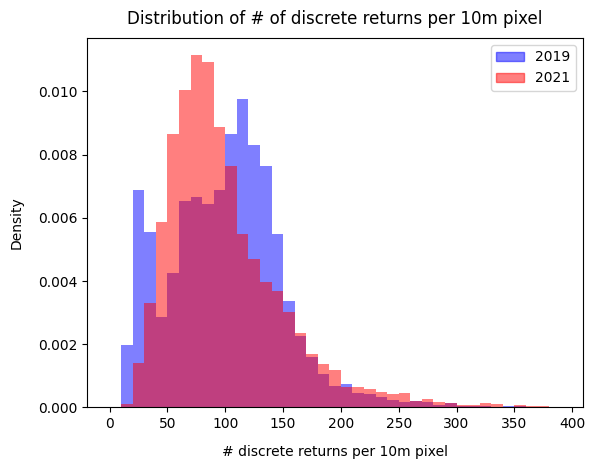

In [ ]:
fig, ax = plt.subplots()
return_counts_per_10m_pixel_2019 = np.unique(df_2019_with_ids["uniq_id"].sort_values(), return_counts=True)[1]
return_counts_per_10m_pixel_2021 = np.unique(df_2021_with_ids["uniq_id"].sort_values(), return_counts=True)[1]
plt.hist(return_counts_per_10m_pixel_2019, bins=np.arange(0,400,10), density=True, alpha=0.5, color="blue")
plt.hist(return_counts_per_10m_pixel_2021, bins=np.arange(0,400,10), density=True, alpha=0.5, color="red")
plt.xlabel("# discrete returns per 10m pixel", labelpad=10)
plt.ylabel("Density", labelpad=10)
plt.title("Distribution of # of discrete returns per 10m pixel", fontsize=12, pad=10)

legend_elements = [Patch(facecolor="blue", edgecolor="blue", label='2019', alpha=0.5),
                  Patch(facecolor="red", edgecolor="red", label='2021', alpha=0.5)]
plt.legend(handles=legend_elements)
plt.show()

### 4. Calculate height percentiles of discrete returns (20th, 30th, 50th, 75th, and 90th) for each 10m pixel.

In [ ]:
## Subset the dataframes to include only the relevant columns
df_2019_sub = pd.concat([df_2019_with_ids["x"], df_2019_with_ids["y"], df_2019_with_ids["uniq_id"], df_2019["discrete_ret_ht_above_ground"]], axis=1)
df_2021_sub = pd.concat([df_2021_with_ids["x"], df_2021_with_ids["y"], df_2021_with_ids["uniq_id"], df_2021["discrete_ret_ht_above_ground"]], axis=1)

## Calculate the number of returns per 10 m pixel
return_counts_per_10m_pixel_2019 = pd.DataFrame(np.unique(df_2019_sub["uniq_id"].sort_values(), return_counts=True)).transpose()
return_counts_per_10m_pixel_2021 = pd.DataFrame(np.unique(df_2021_sub["uniq_id"].sort_values(), return_counts=True)).transpose()
return_counts_per_10m_pixel_2019.columns = return_counts_per_10m_pixel_2021.columns = ["uniq_id", "number_of_returns"]

## Select only those 10m pixels which have greater than 50 returns
return_counts_per_10m_pixel_2019 = return_counts_per_10m_pixel_2019[return_counts_per_10m_pixel_2019["number_of_returns"] > 50].reset_index(drop=True)
return_counts_per_10m_pixel_2021 = return_counts_per_10m_pixel_2021[return_counts_per_10m_pixel_2021["number_of_returns"] > 50].reset_index(drop=True)
valid_10m_pixels_2019 = return_counts_per_10m_pixel_2019["uniq_id"]
valid_10m_pixels_2021 = return_counts_per_10m_pixel_2021["uniq_id"]

## Update df_sub to include only valid 10m pixels (returns > 50)
df_2019_sub = df_2019_sub[df_2019_sub["uniq_id"].isin(valid_10m_pixels_2019)].reset_index(drop=True)
df_2021_sub = df_2021_sub[df_2021_sub["uniq_id"].isin(valid_10m_pixels_2021)].reset_index(drop=True)

In [ ]:
## For each unique id (uniq_id), calculate relative height percentiles (20th, 30th, 50th, 75th and 90th)

## First define a function to calculate the percentile and return a percentile dataframe
def calc_percentile(df,percentile):
    ptile_df = pd.DataFrame(df.groupby(by=["uniq_id"])["discrete_ret_ht_above_ground"].quantile(percentile).reset_index(drop=True))
    ptile_df["RH_ptile"] = percentile*100
    ptile_df.columns = ["height", "RH_ptile"]
    return ptile_df

ptile_20_2019 = calc_percentile(df_2019_sub,0.2)
ptile_30_2019 = calc_percentile(df_2019_sub,0.3)
ptile_50_2019 = calc_percentile(df_2019_sub,0.5)
ptile_75_2019 = calc_percentile(df_2019_sub,0.75)
ptile_90_2019 = calc_percentile(df_2019_sub,0.9)

ptile_20_2021 = calc_percentile(df_2021_sub,0.2)
ptile_30_2021 = calc_percentile(df_2021_sub,0.3)
ptile_50_2021 = calc_percentile(df_2021_sub,0.5)
ptile_75_2021 = calc_percentile(df_2021_sub,0.75)
ptile_90_2021 = calc_percentile(df_2021_sub,0.9)

In [ ]:
rh_percentiles_2019 = pd.concat([ptile_20_2019, ptile_30_2019, ptile_50_2019, ptile_75_2019, ptile_90_2019], axis=0, ignore_index=True)
rh_percentiles_2019["year"] = 2019

rh_percentiles_2021 = pd.concat([ptile_20_2021, ptile_30_2021, ptile_50_2021, ptile_75_2021, ptile_90_2021], axis=0, ignore_index=True)
rh_percentiles_2021["year"] = 2021

## Combine 2019 and 2021 dataframes
rh_percentiles_combined = pd.concat([rh_percentiles_2019, rh_percentiles_2021], axis=0, ignore_index=True)

### 5. Compare the distribution of height percentiles for the years 2019 and 2021.


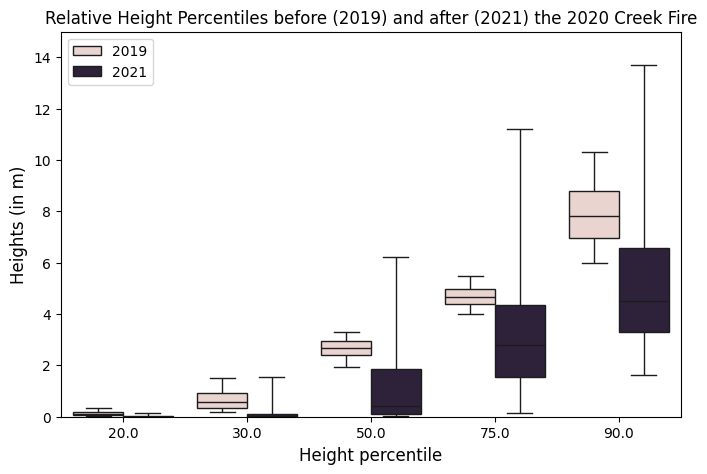

In [ ]:
## Compare boxplots
plt.subplots(figsize=(8,5))
sns.boxplot(x=rh_percentiles_combined["RH_ptile"], y=rh_percentiles_combined["height"], hue=rh_percentiles_combined["year"],
           fliersize=0, whis=[5,95])
plt.ylim(0,15)
plt.xlabel("Height percentile", fontsize=12)
plt.ylabel("Heights (in m)", fontsize=12)
plt.title("Relative Height Percentiles before (2019) and after (2021) the 2020 Creek Fire")
plt.legend(loc='upper left')
plt.show()



---



## Additional Resources

* **L1 Point Clouds (.laz)**: If you'd like to continue exploring the point cloud data in Python using `laspy`, <a href="https://laspy.readthedocs.io/en/latest/complete_tutorial.html" target="_blank"> laspy website </a> has some nice examples you can follow, now that you know how to download NEON point cloud data and read it into Python.
* **L3 Rasters (.tif)**: Refer to the <a href="https://rasterio.readthedocs.io/en/latest/" target="_blank"> rasterio documentation </a> for more options on plotting, and beyond in rasterio.

### Python and Beyond - Other Options for working with Point Cloud Data

There are also a number of open-source tools for working with point-cloud data. Python may not be the best option for developing more rigourous processing workflows, for example. The resources below show some other recommended tools that can be integrated with Python for your analysis:

* <a href="https://rapidlasso.com/lastools/" target="_blank">LAStools</a>
* <a href="https://pdal.io/en/stable/" target="_blank">PDAL (Point Data Abstraction Library)</a>
* <a href="https://plas.io/" target="_blank">plas.io (free, interactive, web-based point cloud visualization)</a>
* <a href="https://r-lidar.github.io/lidRbook/" target="_blank"> lidR (R package for point cloud data)</a>